# Imports

In [ ]:
!pip install pydicom

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import os
import re
import cv2
import pydicom
import nibabel as nib
from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
import math
tf.config.run_functions_eagerly(True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Custom Metrics

In [ ]:
def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels = 6):
    dice = 0
    weights = [0.17649986,  7.78453571, 41.53978194, 65.20657672, 96.75504125,  6.40743063]
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,index], y_pred[:,:,index]) * weights[index]
    return dice/np.sum(weights)

def dice_coef_multilabelloss(y_true, y_pred):
    return 1 - dice_coef_multilabel(y_true, y_pred)

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):
        true = K.cast(true, K.floatx())
        pred = K.cast(pred, K.floatx())

        axis = -1 #if channels last
          #axis=  1 #if channels first


          #argmax returns the index of the element with the greatest value
          #done in the class axis, it returns the class index
        classSelectors = K.argmax(true, axis=axis)
              #if your loss is sparse, use only true as classSelectors

          #considering weights are ordered by class, for each class
          #true(1) if the class index is equal to the weight index
          #weightsList = tf.cast(weightsList, tf.int64)
        classSelectors = [K.equal(tf.cast(i, tf.int64), tf.cast(classSelectors, tf.int64)) for i in range(len(weightsList))]

          #casting boolean to float for calculations
          #each tensor in the list contains 1 where ground true class is equal to its index
          #if you sum all these, you will get a tensor full of ones.
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

          #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)]

          #sums all the selections
          #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


          #make sure your originalLossFunc only collapses the class axis
          #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred)
        loss = loss * weightMultiplier

        return loss
    return lossFunc

# U-Net Implementation

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
    x = tf.keras.layers.concatenate([x, conv_features])
   # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x


def build_unet_model():
    # inputs
    units = 128
    inputs = tf.keras.layers.Input(shape=(units,units,1))
   # encoder: contracting path - downsample
   # 1 - downsample
    f1, p1 = downsample_block(inputs, units/4)
   # 2 - downsample
    f2, p2 = downsample_block(p1, units/2)
   # 3 - downsample
    f3, p3 = downsample_block(p2, units*1)
   # 4 - downsample
    f4, p4 = downsample_block(p3, units*2)
   # 5 - bottleneck
    bottleneck = double_conv_block(p4, units*4)
   # decoder: expanding path - upsample
   # 6 - upsample
    u6 = upsample_block(bottleneck, f4, units*2)
   # 7 - upsample
    u7 = upsample_block(u6, f3, units*1)
   # 8 - upsample
    u8 = upsample_block(u7, f2, units/2)
   # 9 - upsample
    u9 = upsample_block(u8, f1, units/4)
   # outputs
    outputs = tf.keras.layers.Conv2D(6, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
class_weights = [0.17649986,  7.78453571, 41.53978194, 65.20657672, 96.75504125,  6.40743063]

try:
  from tensorflow.keras.models import load_model
  # model = load_model('/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/UnetV_128_epochs.h5', custom_objects={'lossFunc': weightedLoss, 'dice_coef_multilabel': dice_coef_multilabel})
  model = load_model('/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/UnetV_128_epochs_IoUonly.h5', custom_objects={'lossFunc': weightedLoss, 'dice_coef_multilabel': dice_coef_multilabel})
  print("Existing model loaded")
except:
  model = build_unet_model()
  print("New model loaded")

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              # loss=weightedLoss(tf.keras.losses.categorical_crossentropy, class_weights),
              # metrics=[dice_coef_multilabel, tf.keras.metrics.MeanIoU(num_classes=6), "accuracy"])
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=tf.keras.metrics.MeanIoU(num_classes=6))

Existing model loaded


# Model summary

In [ ]:
# model.summary()

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)

# TRAINING

### DataGenerator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, X_set: np.array, y_set: np.array, num_classes: int, batch_size: int) -> None:
        """_Initialization of data generator_

        Parameters
        ----------
        X_set : np.array
            _Set of images_
        y_set : _np.array_
            _Set of masks_
        num_classes : _int_
            _Number of classes_
        batch_size : _int_
            _Size of the batch taken from X_set and y_set_
        """
        self.x, self.y = X_set, y_set
        self.classes = num_classes
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, index):
        """_Get item method for each epoch in training
            and computes categorical values for
            segmentation maks_

        Parameters
        ----------
        index : _int_
            _Integer utilized to return the batches_

        Returns
        -------
        _np.array_
            _Returns the batch from X_set and categorical btach from y_set_
        """
        batch_x = self.x[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]

        train_masks_cat = to_categorical(batch_y, num_classes=self.classes)
        batch_y_categorical = train_masks_cat.reshape((batch_y.shape[0], batch_y.shape[1], batch_y.shape[2], self.classes))

        return batch_x, batch_y_categorical

### Data

In [ ]:
with open(f'/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Data/X_y_segmentations_data_0.npy', 'rb') as f:
        X = np.load(f, allow_pickle = True)
        y = np.load(f, allow_pickle = True)

In [ ]:
# Generate random indices for sampling
indices = np.arange(len(X))
np.random.shuffle(indices)
num_samples = 1000
# Select the first num_samples indices
selected_indices = indices[:num_samples]

# Use the selected indices to extract samples from X and Y
X_test = X[selected_indices]
Y_test = y[selected_indices]

print(X_test.shape, Y_test.shape)

(1000, 128, 128, 1) (1000, 128, 128, 1)


In [ ]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [ ]:
data_generator = DataGenerator(X, y, 6, 128)
data_generator_test = DataGenerator(X_test, Y_test, 6, 128)

In [ ]:
x, Y = data_generator[2]

y_mask = np.argmax(Y, axis=3)

In [ ]:
Y.shape

(128, 128, 128, 6)

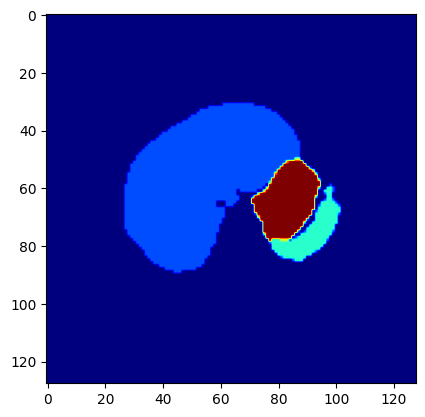

In [ ]:
plt.imshow(y_mask[16,:,:], cmap="jet")

In [ ]:
history = model.fit(data_generator,
                    validation_data=data_generator_test,
                    verbose=1,
                    epochs=32,
                    shuffle=False)

Epoch 1/32


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


124/124 [==============================] - 151s 1s/step - loss: 0.1217 - mean_io_u: 0.6440 - val_loss: 0.1104 - val_mean_io_u: 0.6713
Epoch 2/32
124/124 [==============================] - 108s 870ms/step - loss: 0.1161 - mean_io_u: 0.6510 - val_loss: 0.1058 - val_mean_io_u: 0.6770
Epoch 3/32
124/124 [==============================] - 108s 872ms/step - loss: 0.1109 - mean_io_u: 0.6577 - val_loss: 0.1015 - val_mean_io_u: 0.6828
Epoch 4/32
124/124 [==============================] - 108s 873ms/step - loss: 0.1062 - mean_io_u: 0.6643 - val_loss: 0.0975 - val_mean_io_u: 0.6904
Epoch 5/32
124/124 [==============================] - 108s 873ms/step - loss: 0.1018 - mean_io_u: 0.6705 - val_loss: 0.0938 - val_mean_io_u: 0.6958
Epoch 6/32
124/124 [==============================] - 108s 873ms/step - loss: 0.0976 - mean_io_u: 0.6766 - val_loss: 0.0903 - val_mean_io_u: 0.7012
Epoch 7/32
124/124 [==============================] - 108s 874ms/step - loss: 0.0939 - mean_io_u: 0.6825 - val_loss: 0.0870 - 

In [ ]:
model.save(f'/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/UnetV_128_epochs_IoUonly.h5')

In [ ]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

In [ ]:
# training_plot(["loss", "dice_coef_multilabel", "mean_io_u", "accuracy"], history)
training_plot(["loss", "mean_io_u"], history)

# Evaluation

In [ ]:
from tensorflow.keras.models import load_model

Unet = load_model('/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/UnetV_128_epochs.h5', custom_objects={'lossFunc': weightedLoss, 'dice_coef_multilabel': dice_coef_multilabel})

In [ ]:
class_weights = [0.17649986,  7.78453571, 41.53978194, 65.20657672, 96.75504125,  6.40743063]
Unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=weightedLoss(tf.keras.losses.categorical_crossentropy, class_weights), metrics=[dice_coef_multilabel, tf.keras.metrics.MeanIoU(num_classes=6), "accuracy"])

In [ ]:
with open(f'/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Data/Validation_data/X_y_65504_55928_.npy', 'rb') as f:
        X_val = np.load(f, allow_pickle = True)
        y_val = np.load(f, allow_pickle = True)

In [ ]:
train_masks_cat = to_categorical(y_val, num_classes=6)
y_train_cat = train_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], 6))

In [ ]:
# Evaluation on unseen data
evaluation = Unet.evaluate(X_val, y_train_cat)

In [ ]:
y_pred = Unet.predict(X_val)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
y_pred.shape

In [ ]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

In [ ]:
y_pred[100,:,:,5].dtype

In [ ]:
index = 100

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(X_val[index,:,:], cmap='gray')
axes[0].set_title('Slice')

axes[1].imshow(y_val[index,:,:], cmap='jet')
axes[1].set_title('Ground truth')

axes[2].imshow(y_pred_argmax[index,:,:], cmap='jet')
axes[2].set_title('Prediction')

plt.tight_layout()

# Show the plot
plt.show()